# CVXpy (Waskiri-Sat)
$$
\renewcommand{\bm}[1]{\boldsymbol{#1}}
$$

The purpose of the following optimal control policy is:
- Perform Waskiri-Sat (1U CubeSat that uses only magnetorquers as torque actuator) inertial attitude maneuvers.
- Optimize the total power required during each maneuver.
- Perform agile maneuvers, minimizing as much as possible the settling time.

Optimization problem to solve:

$$
	\begin{align*}
		\text{min} \quad &\int_{0}^{t_f}||\bm{m}(t)||_2^2dt+\int_{0}^{t_f}||\bm{q}(t)-\bm{q}_{t_f}||_2^2dt\\
		\text{s.t.}\quad
		&\dot{\bm{q}}=
		\frac{1}{2}\begin{bmatrix}
			0&-\omega_x&-\omega_y&-\omega_z\\
			\omega_x&0&\omega_z&-\omega_y\\
			\omega_y&-\omega_z&0&\omega_x\\
			\omega_z&\omega_y&-\omega_x&0
		\end{bmatrix}\bm{q}\\
		&\dot{\bm{\omega}}=
		\bm{I}^{-1}(-\bm{\omega}\times\bm{I}\bm{\omega}+\bm{m}\times([B,\text{ECI}]\bm{B}_\text{ECI,Earth}(\bm{r}))\\
		&||\bm{\omega}||_2\leq \omega_{\text{max}}\\
		&||\bm{m}||_\infty\leq m_{\text{max}}\\
		&\bm{q}(0)=\bm{q}_0,\quad\bm{q}(t_f)=\bm{q}_{t_f}\\
		&\bm{w}(0)=\bm{\omega}_0,\quad\bm{\omega}(t_f)=\bm{\omega}_{t_f}
	\end{align*}
$$

This example denotes for instance (not always):
- $\hat{\bm{x}}$ as `x_no_discrete_no_scaled`.
- $\bm{x}$ as `x_no_discrete_scaled`
- $\bm{x}_k$ as `x_discrete_scaled`
- $\bar{\bm{x}}_k$ as `ox_discrete_scaled` (last generated trajectory)

Libraries:

In [430]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R, Slerp
import time
import ecos
import math

import sympy as sp
from sympy.physics.vector import ReferenceFrame

import re

Don't execute if you have already the file 'f_A_B_y_functions.py'

In [377]:
mx, my, mz = sp.symbols('mx my mz')

t = sp.symbols('t')

q0, q1, q2, q3 = sp.symbols('q0 q1 q2 q3')
wx, wy, wz = sp.symbols('wx wy wz')


Ixx, Iyy, Izz = sp.symbols('Ixx Iyy Izz')
Ixy, Ixz, Iyz = sp.symbols('Ixy Ixz Iyz')

n_cubesat, Omega, inc, B0 = sp.symbols('n_cubesat Omega inc B0')

# Rigid body kinematics
BN = sp.Matrix([
    [q0**2 + q1**2 - q2**2 - q3**2, 2*(q1*q2 + q0*q3), 
    2*(-q0*q2 + q1*q3)], [2*(q1*q2 - q0*q3), q0**2 - q1**2 + q2**2 - q3**2, 
    2*(q0*q1 + q2*q3)], [2*(q0*q2 + q1*q3), 2*(-q0*q1 + q2*q3), 
    q0**2 - q1**2 - q2**2 + q3**2]
])

I = sp.Matrix([
    [Ixx, Ixy, Ixz],
    [Ixy, Iyy, Iyz],
    [Ixz, Iyz, Izz]
])

O_B = sp.Matrix([
    -2*sp.sin(inc)*sp.cos(n_cubesat*t),
    -sp.sin(inc)*sp.sin(n_cubesat*t),
    sp.cos(inc)
]) * B0

Nframe = ReferenceFrame('Nframe')
Oframe = Nframe.orientnew('Oframe', 'Body', [Omega, inc, n_cubesat*t], 'ZXZ')

ON = Oframe.dcm(Nframe)

BO = BN * ON.T

Don't execute if you have already the file 'f_A_B_y_functions.py'

In [378]:
w_sympy = sp.Matrix([wx, wy, wz])
m_sympy = sp.Matrix([mx, my, mz])

f_ridig_body = I.inv() * (- w_sympy.cross(I*w_sympy) + m_sympy.cross(BO*O_B))

f1 = 0.5 * (-wx*q1-wy*q2-wz*q3)
f2 = 0.5 * (+wx*q0+wz*q2-wy*q3)
f3 = 0.5 * (+wy*q0-wz*q1+wx*q3)
f4 = 0.5 * (wz*q0+wy*q1-wx*q2)
f5 = f_ridig_body[0]
f6 = f_ridig_body[1]
f7 = f_ridig_body[2]

f_orig_opt_prob=[f1,f2,f3,f4,f5,f6,f7]

f_orig_opt_prob = [fi.simplify(ratio=1) for fi in f_orig_opt_prob]

x_states = [q0,q1,q2,q3,wx,wy,wz]
u_input = [mx,my,mz]

state_parameters_string = [
    "q0",
    "q1",
    "q2",
    "q3",
    "wx",
    "wy",
    "wz"
]

control_parameters_string = [
    "mx",
    "my",
    "mz"
]

time_string = [
    "t"
]

dynamic_parameters_string = [
    "Ixx",
    "Iyy",
    "Izz",
    "Ixy",
    "Ixz",
    "Iyz",
    "n_cubesat",
    "Omega",
    "inc",
    "B0"
]

KeyboardInterrupt: 

Don't execute if you have already the file 'f_A_B_y_functions.py'

In [314]:
def replace_variables_in_string(f_str,
                                state_parameters_string,
                                control_parameters_string,
                                dynamic_parameters_string):

    # Replace states
    for i, var in enumerate(state_parameters_string):
        f_str = re.sub(rf"\b{var}\b", f"hx[{i},0]", f_str)

    # Replace inputs
    for i, var in enumerate(control_parameters_string):
        f_str = re.sub(rf"\b{var}\b", f"hu[{i},0]", f_str)

    # Replace problem parameters
    for i, var in enumerate(dynamic_parameters_string):
        f_str = re.sub(rf"\b{var}\b", f"dyn_par[{i}]", f_str)

    return f_str

def matrix_to_numpy_string(matrix, state_params, control_params, dynamic_params):
    """
    Converts a sympy symbolic matrix into a string representing a numpy.array,
    with optional variable replacement using replace_variables_in_string.

    Args:
        matrix: sympy.Matrix of any dimension.
        state_params, control_params, dynamic_params: strings for variable replacement.

    Returns:
        A string representing a numpy.array ready to be evaluated in Python.
    """

    n_rows, *rest = np.shape(matrix)
    n_cols = rest[0] if rest else 1
    
    matrix = sp.Matrix(n_rows, n_cols, lambda i, j: matrix[i*n_cols + j])

    array_str = "np.array([["

    for i in range(0,n_rows):
        for j in range(0,n_cols):
            array_str += sp.pycode(matrix[i, j])
            if j < n_cols - 1:
                array_str += ","
        if i < n_rows - 1:
            array_str += "],["
        else:
            array_str += "]])"

    # Apply variable replacement using your custom function
    array_str = replace_variables_in_string(array_str,
                                            state_params,
                                            control_params,
                                            dynamic_params)
    return array_str



#Python string creation for f_SCVx

# f
string_f_SCVx =string_f_SCVx=matrix_to_numpy_string(f_orig_opt_prob,
                                                    state_parameters_string,
                                                    control_parameters_string,
                                                    dynamic_parameters_string)
print("\nf_SCVx:\n")
print(string_f_SCVx)

#A, B, y
A_symbolic = sp.Matrix(f_orig_opt_prob).jacobian(x_states) #Sympy Jacobian (Linearization via Taylor series)

string_A_SCVx =string_A_SCVx=matrix_to_numpy_string(A_symbolic,
                                                    state_parameters_string,
                                                    control_parameters_string,
                                                    dynamic_parameters_string)
print("\nA_no_discrete_no_scaled:\n")
print(string_A_SCVx)

B_symbolic = sp.Matrix(f_orig_opt_prob).jacobian(u_input) #Sympy Jacobian (Linearization via Taylor series)

string_B_SCVx =string_B_SCVx=matrix_to_numpy_string(B_symbolic,
                                                    state_parameters_string,
                                                    control_parameters_string,
                                                    dynamic_parameters_string)
print("\nB_no_discrete_no_scaled:\n")
print(string_B_SCVx)

y_symbolic = f_orig_opt_prob-A_symbolic@np.transpose(x_states)-B_symbolic@np.transpose(u_input) #Sympy Jacobian (Linearization via Taylor series)

string_y_SCVx =string_y_SCVx=matrix_to_numpy_string(y_symbolic,
                                                    state_parameters_string,
                                                    control_parameters_string,
                                                    dynamic_parameters_string)
print("\ny_no_discrete_no_scaled:\n")
print(string_y_SCVx)


#Write f, A, B, y functions inside f_A_B_y_functions.py

filename = "f_A_B_y_functions.py"

file_content = f"""
import numpy as np
import math

def f_SCVx(hx, hu, t, dyn_par):
    return {string_f_SCVx}

def A_no_discrete_no_scaled_SCVx(hx, hu, t, dyn_par):
    return {string_A_SCVx}

def B_no_discrete_no_scaled_SCVx(hx, hu, t, dyn_par):
    return {string_B_SCVx}

def y_no_discrete_no_scaled_SCVx(hx, hu, t, dyn_par):
    return {string_y_SCVx}
"""
with open(filename, "w", encoding="utf-8") as f:
    f.write(file_content)
print("\nSymbolic algebra functions implemented!")

NameError: name 'state_parameters_string' is not defined

**Execute!**

In [444]:
from f_A_B_y_functions import *

In [445]:
T = 51-1 # 101-1 means 101 discretization points
tf = 200.0
tau_double = tf/(T)
size_N=5 #discretization accuracy
print("Step: ",tau_double," [s]")

start_quat=np.array([[1],[0],[0],[0]])
#end_quat=np.array([[0.5],[0.4],[0],[(1-0.5**2-0.4**2)**0.5]])
end_quat=np.array([[0],[0],[1],[0]])

start_w_xyz=np.array([[0.1*np.pi/180],[0.2*np.pi/180],[-0.1*np.pi/180]])
end_w_xyz=np.array([[0.0],[0.0],[0.0]])

start_pos_double=np.block([[start_quat],[start_w_xyz]])
end_pos_double=np.block([[end_quat],[end_w_xyz]])

J1_double=0.002 #Kg m^2
J2_double=0.002 #Kg m^2
J3_double=0.002 #Kg m^2

m_max_double = 0.2 #A m^2
omega_max_double = 2.0*np.pi/180 #rad/s

#Circular SSO assumed

mu_earth = 3.986004418e14        # [m^3/s^2] Earth gravitational parameter
R_E = 6378e3               # [m] Earth radius
h_cubesat = 500e3                  # [m] altitude
mu0_over_4pi = 1e-7       # magnetic constant factor
m_E = 7.94e22             # [A·m^2] Earth magnetic dipole moment
a_cubesat = R_E + h_cubesat

n_cubesat_double = np.sqrt(mu_earth / a_cubesat**3)    # rad/s
Omega_double = 0 # Right ascending node
inc_double = 97*math.pi/180 # Satellite inclination SSO
B0_double = mu0_over_4pi * m_E / a_cubesat**3   # Tesla

#Guidance parameters (COGU parameters)

COGU_max_iter = 25

rho0=0.0
rho1=0.1
rho2=0.7
etta0=0.000001
etta1=2
beta_sh=2
beta_gr=2

lamb_double=1000
etta_double_init=1

e_tol=0.005
epsilon_stop_norm=0.00001

#scaling matrices and vectors
S_u_scaling_double=np.array([[2*(0.1*m_max_double),0,0],
                      [0,2*(0.1*m_max_double),0],
                      [0,0,2*(0.1*m_max_double)]])

c_u_scaling_double=np.array([[-(0.1*m_max_double)],
                      [-(0.1*m_max_double)],
                      [-(0.1*m_max_double)]])

S_x_scaling_double=np.array([
                      [2*1,0,0,0,0,0,0],
                      [0,2*1,0,0,0,0,0],
                      [0,0,2*1,0,0,0,0],
                      [0,0,0,2*1,0,0,0],
                      [0,0,0,0,2*(0.5*omega_max_double),0,0],
                      [0,0,0,0,0,2*(0.5*omega_max_double),0],
                      [0,0,0,0,0,0,2*(0.5*omega_max_double)]])
c_x_scaling_double=np.array([
                      [-1],
                      [-1],
                      [-1],
                      [-1],
                      [-(0.5*omega_max_double)],
                      [-(0.5*omega_max_double)],
                      [-(0.5*omega_max_double)]])

states_size = 7
inputs_size = 3
non_convex_inequalities_size = 0

Step:  4.0  [s]


In [446]:
dynamic_parameters_double = [
    J1_double,
    J2_double,
    J3_double,
    0.000,
    0.000,
    0.000,
    n_cubesat_double,
    Omega_double,
    inc_double,
    B0_double
]

Warm starting:

In [447]:
def slerp(q1, q2, num_samples):
    dot = np.dot(q1, q2)
    if dot < 0.0:
        q2 = -q2
        dot = -dot
    dot = np.clip(dot, -1.0, 1.0)
    theta_0 = np.arccos(dot)

    if np.abs(theta_0) < 1e-6:
        return np.linspace(q1, q2, num_samples)

    sin_theta_0 = np.sin(theta_0)

    quaternions = []
    for i in range(num_samples):
        t = i / (num_samples - 1)
        theta = theta_0 * t
        sin_theta = np.sin(theta)
        s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
        s1 = sin_theta / sin_theta_0
        quaternions.append(s0 * q1 + s1 * q2)

    return np.array(quaternions)

def compute_angular_velocity(quaternions, dt):

    rotations = R.from_quat(quaternions)
    angular_velocities = [[0,0,0]]

    for i in range(len(rotations) - 1):
        delta_rot = rotations[i + 1] * rotations[i].inv()
        log_rot = delta_rot.as_rotvec() / dt
        angular_velocities.append(log_rot)

    return np.array(angular_velocities)

# Initial trajectory (without scaling)

ohx_quat = slerp(start_pos_double[0:4,0], end_pos_double[0:4,0],T+1).T
ohx_angvel = compute_angular_velocity(ohx_quat.T, tau_double).T

ohx=np.zeros((7,T+1))
ohx[0:4,:]=ohx_quat
ohx[4:7,:]=ohx_angvel

ohu=np.zeros((inputs_size,T))

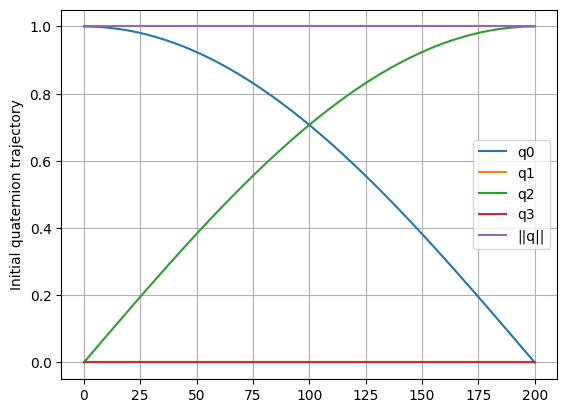

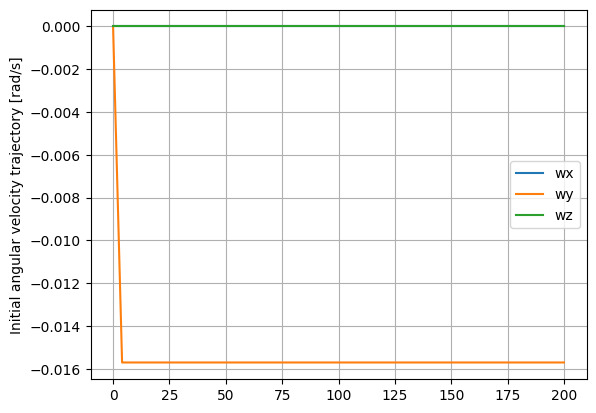

In [448]:
# Plot (scaled initial trajectories)

hu_value=np.copy(ohu)
hx_value=np.copy(ohx)

plt.figure(1)
plt.plot(np.linspace(0, tf, T+1), hx_value[0,:], label='q0')
plt.plot(np.linspace(0, tf, T+1), hx_value[1,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), hx_value[2,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), hx_value[3,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(hx_value[0:4,:],axis=0), label='||q||')
plt.ylabel('Initial quaternion trajectory')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(2)
plt.plot(np.linspace(0, tf, T+1), hx_value[4,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), hx_value[5,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), hx_value[6,:], label='wz')

plt.ylabel('Initial angular velocity trajectory [rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

CVXpy Optimization problem (DPP compliant for cvxpygen)

In [449]:
x = cp.Variable((states_size, T + 1), name='x')
u = cp.Variable((inputs_size, T), name='u')
vc = cp.Variable((states_size, T), name='vc')

A_discrete = cp.Parameter((states_size,states_size*T), name='A_discrete')
B_discrete = cp.Parameter((states_size,inputs_size*T), name='B_discrete')
y_discrete = cp.Parameter((states_size,1*T), name='y_discrete')

tau = cp.Parameter(name='tau')
sqrt_tau = cp.Parameter(name='sqrt_tau')
sqrt_tau_xq_goal = cp.Parameter((4,1), name='sqrt_tau_xq_goal')

start_pos = cp.Parameter((states_size,1), name='start_pos')
end_pos = cp.Parameter((states_size,1), name='end_pos')

ox_cvxpy = cp.Parameter((states_size,T + 1), name='ox_cvxpy')
ou_cvxpy = cp.Parameter((inputs_size,T), name='ou_cvxpy')

S_x_scaling = cp.Parameter((states_size,states_size), name='S_x_scaling')
S_u_scaling = cp.Parameter((inputs_size,inputs_size), name='S_u_scaling')

c_x_scaling = cp.Parameter((states_size,1), name='c_x_scaling')
c_u_scaling = cp.Parameter((inputs_size,1), name='c_u_scaling')

lamb = cp.Parameter(name='lamb')
tau_lamb = cp.Parameter(name='tau_lamb')
etta = cp.Parameter(name='etta')

omega_max = cp.Parameter(name='omega_max')

m_max = cp.Parameter(name='m_max')

constraints = [
    x[:, 0] == start_pos[:,0],
    x[:, T] == end_pos[:,0],
    #u[:, 0] == 0,
    #u[:, T-1] == 0
]

cost = 0

for k in range(0, T):
    cost += cp.sum_squares(sqrt_tau*u[0:3,k:k+1])
    cost += 50*cp.sum_squares(sqrt_tau*x[0:4,k:k+1]-sqrt_tau_xq_goal)
    cost += cp.norm(tau_lamb*vc[0:states_size, k:k+1],1)

for k in range(0, T): # from 0 to T-1
    constraints += [x[0:states_size, k+1:k+2] == A_discrete[0:states_size,states_size*k:states_size*(k+1)] @ x[0:states_size, k:k+1] + B_discrete[0:states_size,inputs_size*k:inputs_size*(k+1)] @ u[0:inputs_size, k:k+1]+y_discrete[0:states_size, k:k+1]+vc[0:states_size, k:k+1]]

for k in range(0, T): # from 0 to T-1
    constraints  += [cp.norm(x[0:states_size, k:k+1]-ox_cvxpy[0:states_size,k:k+1],'inf')+cp.norm(u[0:inputs_size, k:k+1]-ou_cvxpy[0:inputs_size,k:k+1],'inf')<=etta]

constraints  += [cp.norm(x[0:states_size, T:T+1]-ox_cvxpy[0:states_size,T:T+1],'inf')+cp.norm(u[0:inputs_size, T-1:T]-ou_cvxpy[0:inputs_size,T-1:T],'inf')<=etta]

# Convex constraints
for k in range(0, T+1): # from 0 to T
    constraints += [cp.norm(S_x_scaling[4:7,4:7]@x[4:7,k:k+1]+c_x_scaling[4:7,0:1], 2)<=omega_max]
for k in range(0, T): # from 0 to T-1
    constraints += [cp.norm(S_u_scaling[0:3,0:3]@u[0:3,k:k+1]+c_u_scaling[0:3,0:1], 'inf')<=m_max]

objective = cp.Minimize(cost)
problem = cp.Problem(objective, constraints)

In [450]:
print("Is DPP? ", problem.is_dcp(dpp=True))

Is DPP?  True


In [451]:
aux_A_discrete = np.zeros((states_size,states_size*T))
aux_B_discrete = np.zeros((states_size,inputs_size*T))
aux_y_discrete = np.zeros((states_size,1*T))

In [452]:
def SCVx_scaling_x(x_no_scaled,inv_S_x_scaling_double,c_x_scaling_double):
    x_scaled = inv_S_x_scaling_double@(x_no_scaled-c_x_scaling_double)
    return x_scaled
    
def SCVx_scaling_u(u_no_scaled,inv_S_u_scaling_double,c_u_scaling_double):
    u_scaled = inv_S_u_scaling_double@(u_no_scaled-c_u_scaling_double)
    return u_scaled

def SCVx_inv_scaling_x(x_scaled,S_x_scaling_double,c_x_scaling_double):
    x_inv_scaling = S_x_scaling_double@x_scaled+c_x_scaling_double
    return x_inv_scaling
    
def SCVx_inv_scaling_u(u_scaled,S_u_scaling_double,c_u_scaling_double):
    u_inv_scaling = S_u_scaling_double@u_scaled+c_u_scaling_double
    return u_inv_scaling


def A_no_discrete_scaled_SCVx(A_no_discrete_no_scaled, S_x_scaling_double, inv_S_x_scaling_double):

    A_numeric = inv_S_x_scaling_double@A_no_discrete_no_scaled@S_x_scaling_double

    return A_numeric

def B_no_discrete_scaled_SCVx(B_no_discrete_no_scaled,inv_S_x_scaling_double, S_u_scaling_double):

    B_numeric = inv_S_x_scaling_double@B_no_discrete_no_scaled@S_u_scaling_double

    return B_numeric

def y_no_discrete_scaled_SCVx(A_no_discrete_no_scaled,
                              B_no_discrete_no_scaled,
                              y_no_discrete_no_scaled,
                              S_u_scaling_double, S_x_scaling_double, c_x_scaling_double, c_u_scaling_double,
                              inv_S_x_scaling_double):

    y_numeric = inv_S_x_scaling_double@A_no_discrete_no_scaled@c_x_scaling_double
    y_numeric = y_numeric+inv_S_x_scaling_double@B_no_discrete_no_scaled@c_u_scaling_double
    y_numeric = y_numeric+inv_S_x_scaling_double@y_no_discrete_no_scaled

    return y_numeric
    
def A_B_y_discrete_scaled(ox, ou, t0, dynamic_parameters_double, tau_double,
                          S_x_scaling_double, c_x_scaling_double, inv_S_x_scaling_double,
                          S_u_scaling_double, c_u_scaling_double, inv_S_u_scaling_double, size_N):
    
    ohx = SCVx_inv_scaling_x(ox, S_x_scaling_double, c_x_scaling_double)
    ohu = SCVx_inv_scaling_u(ou, S_u_scaling_double, c_u_scaling_double)

    n = len(ohx)
    m = len(ohu)

    Phi = np.eye(n)
    G   = np.zeros((n, m))
    z   = np.zeros((n, 1))

    dt = tau_double / (size_N - 1)
    t  = t0

    for i in range(size_N - 1):

        # ===== k1 =====
        A1_no = A_no_discrete_no_scaled_SCVx(ohx, ohu, t, dynamic_parameters_double)
        B1_no = B_no_discrete_no_scaled_SCVx(ohx, ohu, t, dynamic_parameters_double)
        y1_no = y_no_discrete_no_scaled_SCVx(ohx, ohu, t, dynamic_parameters_double)

        A1 = A_no_discrete_scaled_SCVx(A1_no, S_x_scaling_double, inv_S_x_scaling_double)
        B1 = B_no_discrete_scaled_SCVx(B1_no, inv_S_x_scaling_double, S_u_scaling_double)
        y1 = y_no_discrete_scaled_SCVx(A1_no, B1_no, y1_no,
                                       S_u_scaling_double, S_x_scaling_double, c_x_scaling_double, c_u_scaling_double,
                                       inv_S_x_scaling_double)

        k1_Phi = A1 @ Phi
        k1_G   = A1 @ G + B1
        k1_z   = A1 @ z + y1

        # ===== k2 =====
        t2 = t + 0.5*dt
        Phi2 = Phi + 0.5*dt*k1_Phi
        G2   = G   + 0.5*dt*k1_G
        z2   = z   + 0.5*dt*k1_z

        A2_no = A_no_discrete_no_scaled_SCVx(ohx, ohu, t2, dynamic_parameters_double)
        B2_no = B_no_discrete_no_scaled_SCVx(ohx, ohu, t2, dynamic_parameters_double)
        y2_no = y_no_discrete_no_scaled_SCVx(ohx, ohu, t2, dynamic_parameters_double)

        A2 = A_no_discrete_scaled_SCVx(A2_no, S_x_scaling_double, inv_S_x_scaling_double)
        B2 = B_no_discrete_scaled_SCVx(B2_no, inv_S_x_scaling_double, S_u_scaling_double)
        y2 = y_no_discrete_scaled_SCVx(A2_no, B2_no, y2_no,
                                       S_u_scaling_double, S_x_scaling_double, c_x_scaling_double, c_u_scaling_double,
                                       inv_S_x_scaling_double)

        k2_Phi = A2 @ Phi2
        k2_G   = A2 @ G2 + B2
        k2_z   = A2 @ z2 + y2

        # ===== k3 =====
        Phi3 = Phi + 0.5*dt*k2_Phi
        G3   = G   + 0.5*dt*k2_G
        z3   = z   + 0.5*dt*k2_z

        A3_no = A_no_discrete_no_scaled_SCVx(ohx, ohu, t2, dynamic_parameters_double)
        B3_no = B_no_discrete_no_scaled_SCVx(ohx, ohu, t2, dynamic_parameters_double)
        y3_no = y_no_discrete_no_scaled_SCVx(ohx, ohu, t2, dynamic_parameters_double)

        A3 = A_no_discrete_scaled_SCVx(A3_no, S_x_scaling_double, inv_S_x_scaling_double)
        B3 = B_no_discrete_scaled_SCVx(B3_no, inv_S_x_scaling_double, S_u_scaling_double)
        y3 = y_no_discrete_scaled_SCVx(A3_no, B3_no, y3_no,
                                       S_u_scaling_double, S_x_scaling_double, c_x_scaling_double, c_u_scaling_double,
                                       inv_S_x_scaling_double)

        k3_Phi = A3 @ Phi3
        k3_G   = A3 @ G3 + B3
        k3_z   = A3 @ z3 + y3

        # ===== k4 =====
        t4 = t + dt
        Phi4 = Phi + dt*k3_Phi
        G4   = G   + dt*k3_G
        z4   = z   + dt*k3_z

        A4_no = A_no_discrete_no_scaled_SCVx(ohx, ohu, t4, dynamic_parameters_double)
        B4_no = B_no_discrete_no_scaled_SCVx(ohx, ohu, t4, dynamic_parameters_double)
        y4_no = y_no_discrete_no_scaled_SCVx(ohx, ohu, t4, dynamic_parameters_double)

        A4 = A_no_discrete_scaled_SCVx(A4_no, S_x_scaling_double, inv_S_x_scaling_double)
        B4 = B_no_discrete_scaled_SCVx(B4_no, inv_S_x_scaling_double, S_u_scaling_double)
        y4 = y_no_discrete_scaled_SCVx(A4_no, B4_no, y4_no,
                                       S_u_scaling_double, S_x_scaling_double, c_x_scaling_double, c_u_scaling_double,
                                       inv_S_x_scaling_double)

        k4_Phi = A4 @ Phi4
        k4_G   = A4 @ G4 + B4
        k4_z   = A4 @ z4 + y4

        # ===== Update =====
        Phi += (dt/6)*(k1_Phi + 2*k2_Phi + 2*k3_Phi + k4_Phi)
        G   += (dt/6)*(k1_G   + 2*k2_G   + 2*k3_G   + k4_G)
        z   += (dt/6)*(k1_z   + 2*k2_z   + 2*k3_z   + k4_z)

        t += dt

    return Phi, G, z

In [453]:
def f_rk4_step(xk, uk, t, dt, dynamic_parameters,
               S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double):
    
    xk_no_scaled = SCVx_inv_scaling_x(xk,S_x_scaling_double,c_x_scaling_double)
    uk_no_scaled = SCVx_inv_scaling_u(uk,S_u_scaling_double,c_u_scaling_double)
    k1 = f_SCVx(xk_no_scaled, uk_no_scaled, t, dynamic_parameters)
    k2 = f_SCVx(xk_no_scaled + 0.5 * dt * k1, uk_no_scaled, t + 0.5*dt, dynamic_parameters)
    k3 = f_SCVx(xk_no_scaled + 0.5 * dt * k2, uk_no_scaled, t + 0.5*dt, dynamic_parameters)
    k4 = f_SCVx(xk_no_scaled + dt * k3, uk_no_scaled, t + dt, dynamic_parameters)
    return xk_no_scaled + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def f_Euler_step(xk, uk, t, dt, dynamic_parameters,
                 S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double):

    xk_no_scaled = SCVx_inv_scaling_x(xk,S_x_scaling_double,c_x_scaling_double)
    uk_no_scaled = SCVx_inv_scaling_u(uk,S_u_scaling_double,c_u_scaling_double)

    return xk_no_scaled + dt * f_SCVx(xk_no_scaled, uk_no_scaled, t, dynamic_parameters)

def J_SCVx(x,u,T,tau_double, dynamic_parameters, xq_goal_double,
           S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double):
    
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau_double*np.linalg.norm(u[0:3,k:k+1], ord=2)**2
        cost += 50*tau_double*np.linalg.norm(x[0:4,k:k+1]-xq_goal_double, ord=2)**2

    for k in range(0, T): # from 0 to T-1

        flow_map = f_rk4_step(x[0:, k:k+1], u[:, k:k+1], k/T*tf, tau_double, dynamic_parameters,
        S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double)

        SCVx_defect = SCVx_inv_scaling_x(x[:, k+1:k+2],S_x_scaling_double,c_x_scaling_double)-flow_map

        cost += tau_double*np.linalg.norm(lamb_double*SCVx_defect, ord=1)

    return cost

In [454]:
ox = np.zeros((states_size,T+1))
ou = np.zeros((inputs_size,T))
etta_double = etta_double_init

inv_S_x_scaling_double = np.linalg.inv(S_x_scaling_double)
inv_S_u_scaling_double = np.linalg.inv(S_u_scaling_double)

for t in range(0, T + 1):
    ox[0:states_size,t:t+1] = SCVx_scaling_x(ohx[0:states_size,t:t+1],inv_S_x_scaling_double,c_x_scaling_double)

for t in range(0, T):
    ou[0:inputs_size,t:t+1] = SCVx_scaling_u(ohu[0:inputs_size,t:t+1],inv_S_u_scaling_double,c_u_scaling_double)

ox_cvxpy.value=ox #trajectory initialization (already scaled)
ou_cvxpy.value=ou #trajectory initialization (already scaled)

tau.value = tau_double
sqrt_tau.value = (tau_double)**0.5

lamb.value = lamb_double

tau_lamb.value = tau_double*lamb_double
etta.value = etta_double

S_x_scaling.value = S_x_scaling_double
S_u_scaling.value = S_u_scaling_double

c_x_scaling.value = c_x_scaling_double
c_u_scaling.value = c_u_scaling_double

omega_max.value = omega_max_double
m_max.value = m_max_double

start_pos.value = SCVx_scaling_x(start_pos_double,inv_S_x_scaling_double,c_x_scaling_double)
end_pos.value = SCVx_scaling_x(end_pos_double,inv_S_x_scaling_double,c_x_scaling_double)

aux_end_pos_double = SCVx_scaling_x(end_pos_double,inv_S_x_scaling_double,c_x_scaling_double)
sqrt_tau_xq_goal_double = (tau_double)**0.5*aux_end_pos_double[0:4,0:1]
xq_goal_double = np.copy(aux_end_pos_double[0:4,0:1])
sqrt_tau_xq_goal.value = np.copy(sqrt_tau_xq_goal_double)

t0 = time.time()

i=1
no_first_iterations = False
rho_i = "None"

for COGU_iter in range(COGU_max_iter):

    for k in range(0, T):
        aux_aux_A_discrete, aux_aux_B_discrete, aux_aux_y_discrete = A_B_y_discrete_scaled(ox[0:states_size,k:k+1], ou[0:inputs_size,k:k+1], k/T*tf, dynamic_parameters_double, tau_double,
                          S_x_scaling_double, c_x_scaling_double, inv_S_x_scaling_double, 
                          S_u_scaling_double, c_u_scaling_double, inv_S_u_scaling_double , size_N)

        aux_A_discrete[0:states_size,states_size*k:states_size*(k+1)] = np.copy(aux_aux_A_discrete)
        
        aux_B_discrete[0:states_size,inputs_size*k:inputs_size*(k+1)] = np.copy(aux_aux_B_discrete)
        
        aux_y_discrete[0:states_size,k:k+1] = np.copy(aux_aux_y_discrete)
    
    #print(aux_B_discrete_qw_scaled[0:7,3*10:3*10+3])

    A_discrete.value = np.copy(aux_A_discrete)
    B_discrete.value = np.copy(aux_B_discrete)
    y_discrete.value = np.copy(aux_y_discrete)

    val=problem.solve(solver='ECOS',ignore_dpp=True) #IF YOU USE CVXPYGEN: ignore_dpp=False

    vc_opt=np.copy(vc.value)
    x_opt=np.copy(x.value)
    u_opt=np.copy(u.value)

    L_SCVx_opt=val

    J_SCVx_opt=J_SCVx(x_opt,u_opt,T,tau_double, dynamic_parameters_double, xq_goal_double,
                      S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double)
    oJ_SCVx=J_SCVx(ox,ou,T,tau_double, dynamic_parameters_double, xq_goal_double,
                      S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double)
    
    print("Iteration number: ",i," Etta: ",etta.value, " Rho: ",rho_i)
    print("L_SCVx_opt: "+str(val)+" J_SCVx_opt: "+str(J_SCVx_opt)+" oJ_SCVx: "+str(oJ_SCVx)+" Norm_x_diff: "+str(np.max(np.linalg.norm((x_opt-ox), ord=2,axis=0))),"\n")

    
    Delta_J_SCVx=oJ_SCVx-J_SCVx_opt
    #Delta_L_SCVx=J_SCVx_opt-L_SCVx_opt
    Delta_L_SCVx=oJ_SCVx-L_SCVx_opt

    if (Delta_L_SCVx<e_tol*np.abs(oJ_SCVx) or np.max(np.linalg.norm((x_opt-ox), ord=1,axis=0))<epsilon_stop_norm) and no_first_iterations:
      x_global=np.copy(ox)
      u_global=np.copy(ou)
      print("Maximum iterations unreached! :)")
      break;
    else:
      rho_i=Delta_J_SCVx/Delta_L_SCVx
      if rho_i<rho0:
        etta.value=max([etta0,etta.value/beta_sh])
        ox=np.copy(ox)
        ou=np.copy(ou)
      if rho_i>=rho0 and rho_i<rho1:
        etta.value=max([etta0,etta.value/beta_sh])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho1 and rho_i<rho2:
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho2:
        etta.value=min([etta1,beta_gr*etta.value])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)

    ox_cvxpy.value=np.copy(ox)
    ou_cvxpy.value=np.copy(ou)

    if i==3:
        no_first_iterations = True
    i=i+1
    
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

Iteration number:  1  Etta:  1  Rho:  None
L_SCVx_opt: 2030.6369288702897 J_SCVx_opt: 5584.265607883195 oJ_SCVx: 17952.377936166155 Norm_x_diff: 0.9040348437183227 

Iteration number:  2  Etta:  2  Rho:  0.7768065265359789
L_SCVx_opt: 1498.3550482728574 J_SCVx_opt: 4433.789518521122 oJ_SCVx: 5584.265607883195 Norm_x_diff: 0.7309389083856924 

Iteration number:  3  Etta:  2  Rho:  0.2815715304036883
L_SCVx_opt: 1234.5323293553224 J_SCVx_opt: 1878.9129119614915 oJ_SCVx: 4433.789518521122 Norm_x_diff: 0.3174509947856966 

Iteration number:  4  Etta:  2  Rho:  0.7985843136374445
L_SCVx_opt: 1142.5652215497128 J_SCVx_opt: 1278.336709074754 oJ_SCVx: 1878.9129119614915 Norm_x_diff: 0.17244497069383255 

Iteration number:  5  Etta:  2  Rho:  0.8156149747015361
L_SCVx_opt: 1144.2616620990257 J_SCVx_opt: 1222.4493001297903 oJ_SCVx: 1278.336709074754 Norm_x_diff: 0.098791415414096 

Iteration number:  6  Etta:  2  Rho:  0.41683676571883654
L_SCVx_opt: 1140.0280840020177 J_SCVx_opt: 1182.336312555

In [455]:
print(np.linalg.norm((vc.value[:, :]), ord=1))

print("vc error (quaternion):")
print(np.linalg.norm((vc.value[0:4, :]), ord=1))

print("vc error (ang. velocity):")
print(np.linalg.norm((vc.value[4:7, :]), ord=1))

0.004719260963543708
vc error (quaternion):
0.004719258255566528
vc error (ang. velocity):
2.955284842609778e-09


[-1.]
[-0.99893478]
[-0.9896568]
[-0.96378652]
[-0.9176071]
[-0.85372072]
[-0.77334037]
[-0.6779773]
[-0.56944785]
[-0.44984792]
[-0.32151536]
[-0.18698277]
[-0.04891926]
[0.08993684]
[0.22685137]
[0.35916654]
[0.48400252]
[0.59740674]
[0.69576106]
[0.77746812]
[0.84264233]
[0.89262671]
[0.92948484]
[0.95556723]
[0.97319596]
[0.98446928]
[0.99116511]
[0.99471521]
[0.99622322]
[0.99650595]
[0.99614326]
[0.99552789]
[0.99491029]
[0.99443647]
[0.99417834]
[0.99415726]
[0.99436151]
[0.99475904]
[0.99530646]
[0.99595518]
[0.99665582]
[0.99736119]
[0.99802884]
[0.99862313]
[0.99911743]
[0.99949613]
[0.99975645]
[0.99990944]
[0.99997914]
[0.99999852]
[1.]


C:\Users\franklin\AppData\Local\Temp\ipykernel_17292\3697303151.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point_error[0,i] = math.acos(BR[2,2])


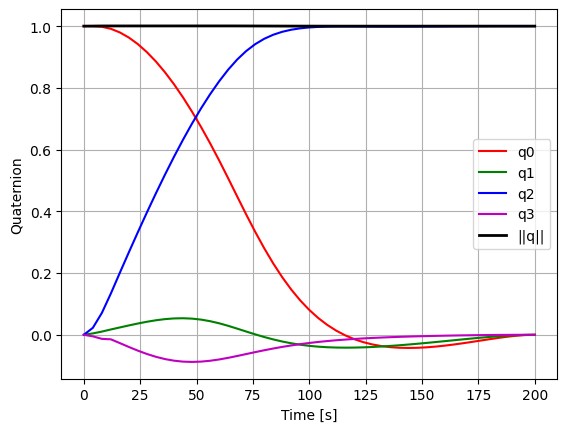

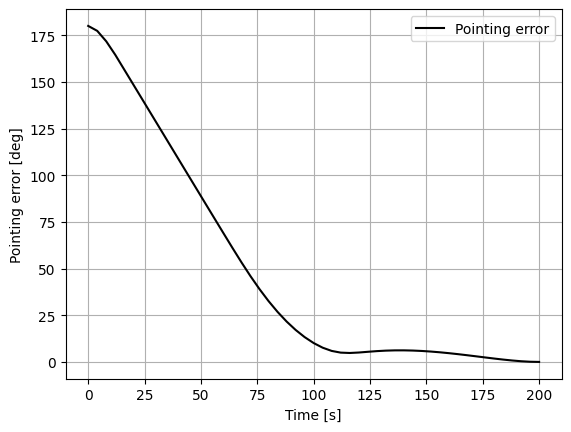

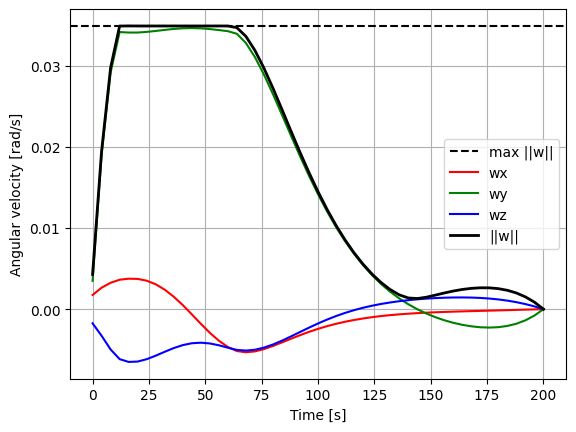

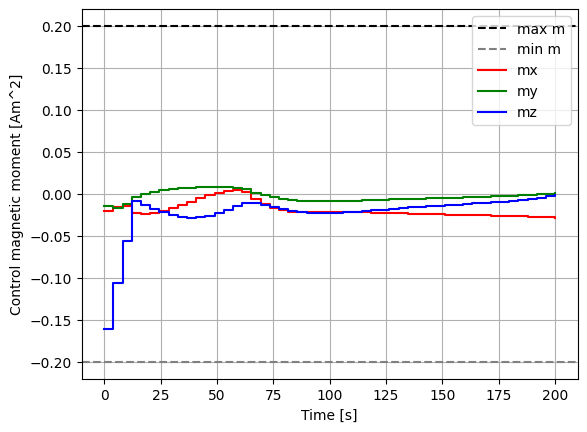

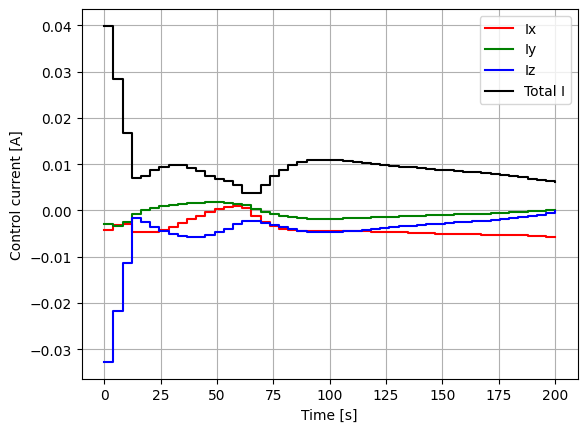

In [456]:
# Plot (scaled initial trajectories)
def global_inv_scaling(x,S,c,T):
    for i in range(0,T,1):
        x[:,i:i+1]=S@x[:,i:i+1]+c
    return x
#x_value = np.copy(x_global)
#u_value = np.copy(u_global)
x_value=global_inv_scaling(np.copy(ox),S_x_scaling_double,c_x_scaling_double,T+1)
u_value=global_inv_scaling(np.copy(ou),S_u_scaling_double,c_u_scaling_double,T)

t1 = np.linspace(0, tf, T+1)
t2 = np.linspace(0, tf, T)

# --- Quaternion ---
plt.figure(1)
for i,c in zip(range(4),['r','g','b','m']):
    plt.plot(t1, x_value[i,:], c, label=f'q{i}')
plt.plot(t1, np.linalg.norm(x_value[0:4,:],axis=0), 'k', lw=2, label='||q||')
plt.grid(); plt.legend(); plt.xlabel('Time [s]');plt.ylabel('Quaternion')

# --- Pointing error ---
plt.figure(2)

rot_RN = R.from_quat(end_quat.T)
RN = rot_RN.as_matrix()
point_error = np.zeros((1,T+1))

for i in range(0,T+1):
    rot_BN = R.from_quat(x_value[0:4,i])
    BN = rot_BN.as_matrix()
    BR = BN@RN.T
    print(BR[2,2])
    point_error[0,i] = math.acos(BR[2,2])

plt.plot(t1, point_error[0,:]*180/np.pi, 'k', label='Pointing error')
plt.grid(); plt.legend(); plt.xlabel('Time [s]');plt.ylabel('Pointing error [deg]')


# --- Angular velocity ---
plt.figure(4)
plt.axhline( omega_max_double, c='k', ls='--', label='max ||w||')
for i,c,l in zip(range(4,7),['r','g','b'],['wx','wy','wz']):
    plt.plot(t1, x_value[i,:], c, label=l)
plt.plot(t1, np.linalg.norm(x_value[4:7,:],axis=0), 'k', lw=2, label='||w||')
plt.grid(); plt.legend(); plt.xlabel('Time [s]'); plt.ylabel('Angular velocity [rad/s]')

# --- Magnetic moment ---
plt.figure(6)
plt.axhline( m_max_double, c='k', ls='--', label='max m')
plt.axhline(-m_max_double, c='gray', ls='--', label='min m')
for i,c,l in zip(range(3),['r','g','b'],['mx','my','mz']):
    plt.step(t2, u_value[i,:], c, where='post', label=l)
plt.grid(); plt.legend(); plt.xlabel('Time [s]');plt.ylabel('Control magnetic moment [Am^2]')

plt.show()

# --- Current ---
n_turns = 1000
A = 0.07*0.07

plt.figure(6)

for i,c,l in zip(range(3),['r','g','b'],['Ix','Iy','Iz']):
    plt.step(t2, u_value[i,:]/(n_turns*A), c, where='post', label=l)
plt.step(t2, np.sum(np.abs(u_value[:,:]/(n_turns*A)),axis = 0), 'k', where='post', label="Total I")
plt.grid(); plt.legend(); plt.xlabel('Time [s]');plt.ylabel('Control current [A]')


plt.show()

# CVXpygen (Waskiri-Sat)

In [82]:
from cvxpygen import cpg
cpg.generate_code(problem, code_dir='WaskiriSat_SCVX_ECOS_T51_l2_q',solver='ECOS')

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Generating code with CVXPYgen ...
CVXPYgen finished generating code.
Compiling python wrapper with CVXPYgen ... 


c:\Users\franklin\anaconda3\envs\cvxpygen\lib\site-packages\setuptools\__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)


CVXPYgen finished compiling python wrapper.
-- Selecting Windows SDK version 10.0.26100.0 to target Windows 10.0.26200.
-- The C compiler identification is MSVC 19.44.35219.0
-- The CXX compiler identification is MSVC 19.44.35219.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: C:/Program Files/Microsoft Visual Studio/2022/Community/VC/Tools/MSVC/14.44.35207/bin/Hostx64/x64/cl.exe - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: C:/Program Files/Microsoft Visual Studio/2022/Community/VC/Tools/MSVC/14.44.35207/bin/Hostx64/x64/cl.exe - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (3.0s)
-- Generating done (0.1s)
-- Build files have been written to: C:/Users/franklin/Documents/Kyutech/Thesis/Papers/githubs/github_COGU/COGU_algorithm

In [364]:
from WaskiriSat_SCVX_ECOS_T51_l2_q.cpg_solver import cpg_solve #CHANGE
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

with open('WaskiriSat_SCVX_ECOS_T51_l2_q/problem.pickle', 'rb') as file: #CHANGE
    problem = pickle.load(file)

problem.register_solve('cpg', cpg_solve)

In [183]:
ox = np.zeros((states_size,T+1))
ou = np.zeros((inputs_size,T))
etta_double = etta_double_init

inv_S_x_scaling_double = np.linalg.inv(S_x_scaling_double)
inv_S_u_scaling_double = np.linalg.inv(S_u_scaling_double)

for t in range(0, T + 1):
    ox[0:states_size,t:t+1] = SCVx_scaling_x(ohx[0:states_size,t:t+1],inv_S_x_scaling_double,c_x_scaling_double)

for t in range(0, T):
    ou[0:inputs_size,t:t+1] = SCVx_scaling_u(ohu[0:inputs_size,t:t+1],inv_S_u_scaling_double,c_u_scaling_double)

problem.param_dict['ox_cvxpy'].value=ox #trajectory initialization (already scaled)
problem.param_dict['ou_cvxpy'].value=ou #trajectory initialization (already scaled)

#problem.param_dict['tau'].value = tau_double
problem.param_dict['sqrt_tau'].value = (tau_double)**0.5

#problem.param_dict['lamb'].value = lamb_double

problem.param_dict['tau_lamb'].value = tau_double*lamb_double
problem.param_dict['etta'].value = etta_double

problem.param_dict['S_x_scaling'].value = S_x_scaling_double
problem.param_dict['S_u_scaling'].value = S_u_scaling_double

problem.param_dict['c_x_scaling'].value = c_x_scaling_double
problem.param_dict['c_u_scaling'].value = c_u_scaling_double

problem.param_dict['omega_max'].value = omega_max_double
problem.param_dict['m_max'].value = m_max_double

problem.param_dict['start_pos'].value = SCVx_scaling_x(start_pos_double,inv_S_x_scaling_double,c_x_scaling_double)
problem.param_dict['end_pos'].value = SCVx_scaling_x(end_pos_double,inv_S_x_scaling_double,c_x_scaling_double)

aux_end_pos_double = SCVx_scaling_x(end_pos_double,inv_S_x_scaling_double,c_x_scaling_double)
sqrt_tau_xq_goal_double = (tau_double)**0.5*aux_end_pos_double[0:4,0:1]
xq_goal_double = np.copy(aux_end_pos_double[0:4,0:1])
problem.param_dict['sqrt_tau_xq_goal'].value = np.copy(sqrt_tau_xq_goal_double)

t0 = time.time()

i=1
no_first_iterations = False
rho_i = "None"

for COGU_iter in range(COGU_max_iter):

    for k in range(0, T):
        aux_aux_A_discrete, aux_aux_B_discrete, aux_aux_y_discrete = A_B_y_discrete_scaled(ox[0:states_size,k:k+1], ou[0:inputs_size,k:k+1], k/T*tf, dynamic_parameters_double, tau_double,
                          S_x_scaling_double, c_x_scaling_double, inv_S_x_scaling_double, 
                          S_u_scaling_double, c_u_scaling_double, inv_S_u_scaling_double , size_N)

        aux_A_discrete[0:states_size,states_size*k:states_size*(k+1)] = np.copy(aux_aux_A_discrete)
        
        aux_B_discrete[0:states_size,inputs_size*k:inputs_size*(k+1)] = np.copy(aux_aux_B_discrete)
        
        aux_y_discrete[0:states_size,k:k+1] = np.copy(aux_aux_y_discrete)
    
    #print(aux_B_discrete_qw_scaled[0:7,3*10:3*10+3])

    problem.param_dict['A_discrete'].value = np.copy(aux_A_discrete)
    problem.param_dict['B_discrete'].value = np.copy(aux_B_discrete)
    problem.param_dict['y_discrete'].value = np.copy(aux_y_discrete)

    val=problem.solve(method='cpg') #IF YOU USE CVXPYGEN: ignore_dpp=False

    vc_opt=np.copy(problem.var_dict['vc'].value)
    x_opt=np.copy(problem.var_dict['x'].value)
    u_opt=np.copy(problem.var_dict['u'].value)

    L_SCVx_opt=val

    J_SCVx_opt=J_SCVx(x_opt,u_opt,T,tau_double, dynamic_parameters_double, xq_goal_double,
                      S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double)
    oJ_SCVx=J_SCVx(ox,ou,T,tau_double, dynamic_parameters_double, xq_goal_double,
                      S_x_scaling_double,c_x_scaling_double,S_u_scaling_double,c_u_scaling_double)
    
    print("Iteration number: ",i," Etta: ",problem.param_dict['etta'].value, " Rho: ",rho_i)
    print("L_SCVx_opt: "+str(val)+" J_SCVx_opt: "+str(J_SCVx_opt)+" oJ_SCVx: "+str(oJ_SCVx)+" Norm_x_diff: "+str(np.max(np.linalg.norm((x_opt-ox), ord=2,axis=0))),"\n")

    
    Delta_J_SCVx=oJ_SCVx-J_SCVx_opt
    #Delta_L_SCVx=J_SCVx_opt-L_SCVx_opt
    Delta_L_SCVx=oJ_SCVx-L_SCVx_opt

    if (Delta_L_SCVx<e_tol*np.abs(oJ_SCVx) or np.max(np.linalg.norm((x_opt-ox), ord=1,axis=0))<epsilon_stop_norm) and no_first_iterations:
      x_global=np.copy(ox)
      u_global=np.copy(ou)
      print("Maximum iterations unreached! :)")
      break;
    else:
      rho_i=Delta_J_SCVx/Delta_L_SCVx
      if rho_i<rho0:
        problem.param_dict['etta'].value=max([etta0,problem.param_dict['etta'].value/beta_sh])
        ox=np.copy(ox)
        ou=np.copy(ou)
      if rho_i>=rho0 and rho_i<rho1:
        problem.param_dict['etta'].value=max([etta0,problem.param_dict['etta'].value/beta_sh])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho1 and rho_i<rho2:
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho2:
        problem.param_dict['etta'].value=min([etta1,beta_gr*problem.param_dict['etta'].value])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)

    problem.param_dict['ox_cvxpy'].value=np.copy(ox)
    problem.param_dict['ou_cvxpy'].value=np.copy(ou)


    if i==3:
        no_first_iterations = True
    i=i+1
    
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

Iteration number:  1  Etta:  1  Rho:  None
L_SCVx_opt: 11209.76763410774 J_SCVx_opt: 29871.704989880614 oJ_SCVx: 48702.51015967176 Norm_x_diff: 1.2247448715028426 

Iteration number:  2  Etta:  1  Rho:  0.5022520066904032
L_SCVx_opt: 2467.46065811926 J_SCVx_opt: 16610.866880134836 oJ_SCVx: 29871.704989880614 Norm_x_diff: 0.8983202039780007 

Iteration number:  3  Etta:  1  Rho:  0.4838972368370161
L_SCVx_opt: 647.2442025102534 J_SCVx_opt: 7008.181259680852 oJ_SCVx: 16610.866880134836 Norm_x_diff: 0.7029635725606088 

Iteration number:  4  Etta:  1  Rho:  0.601535491935273
L_SCVx_opt: 1165.8357678053094 J_SCVx_opt: 10333.092966885204 oJ_SCVx: 7008.181259680852 Norm_x_diff: 0.8697557958582323 

Iteration number:  5  Etta:  0.5  Rho:  -0.5691056292079998
L_SCVx_opt: 1297.8369676119971 J_SCVx_opt: 5274.106548846249 oJ_SCVx: 7008.181259680852 Norm_x_diff: 0.51234925889483 

Iteration number:  6  Etta:  0.5  Rho:  0.3036725321874329
L_SCVx_opt: 1334.6577350914822 J_SCVx_opt: 4799.54388503276

C:\Users\franklin\AppData\Local\Temp\ipykernel_17292\3005292964.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point_error[0,i] = math.acos(BR[2,2])


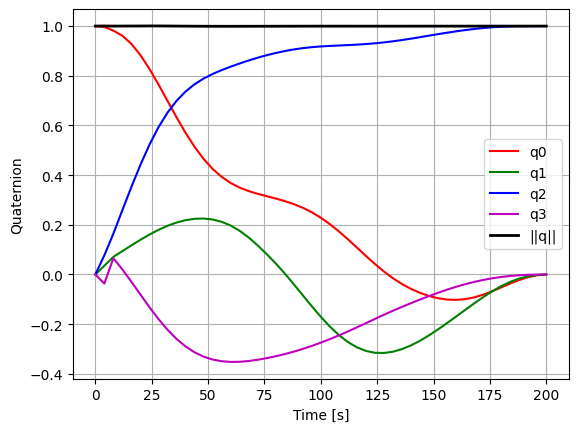

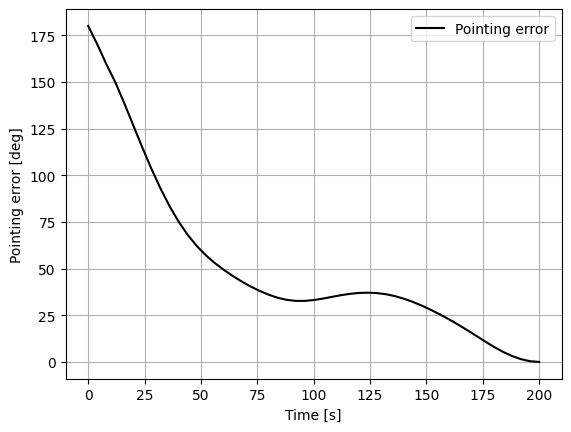

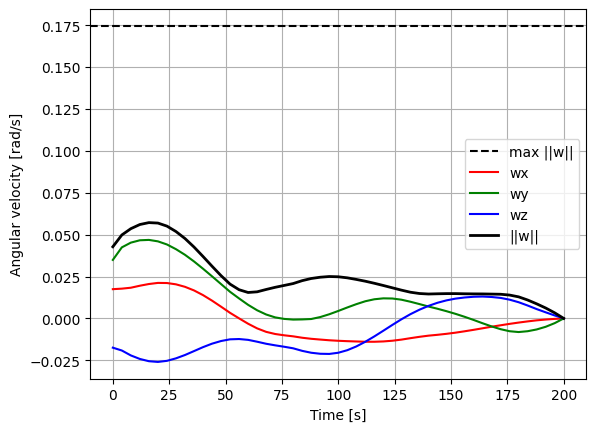

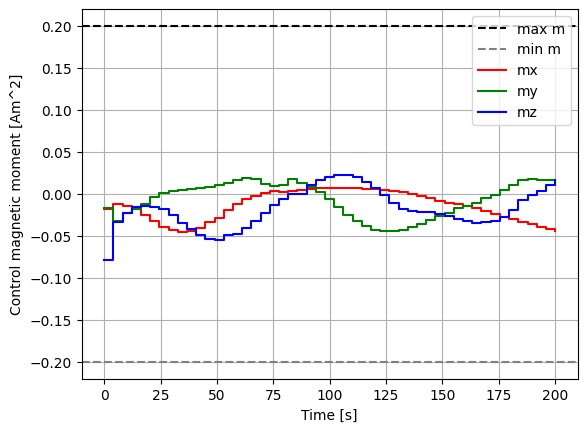

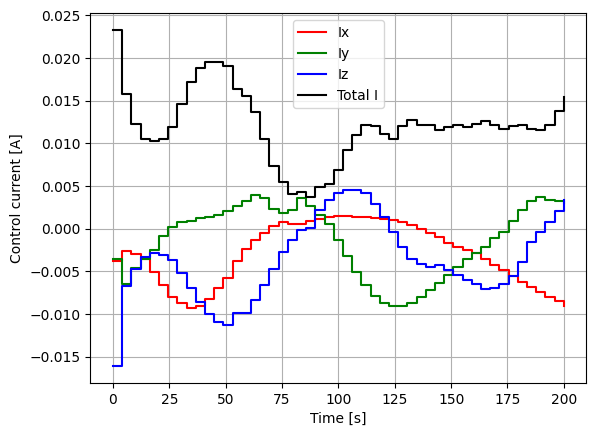

In [184]:
# Plot (scaled initial trajectories)
def global_inv_scaling(x,S,c,T):
    for i in range(0,T,1):
        x[:,i:i+1]=S@x[:,i:i+1]+c
    return x
#x_value = np.copy(x_global)
#u_value = np.copy(u_global)
x_value=global_inv_scaling(np.copy(ox),S_x_scaling_double,c_x_scaling_double,T+1)
u_value=global_inv_scaling(np.copy(ou),S_u_scaling_double,c_u_scaling_double,T)

t1 = np.linspace(0, tf, T+1)
t2 = np.linspace(0, tf, T)

# --- Quaternion ---
plt.figure(1)
for i,c in zip(range(4),['r','g','b','m']):
    plt.plot(t1, x_value[i,:], c, label=f'q{i}')
plt.plot(t1, np.linalg.norm(x_value[0:4,:],axis=0), 'k', lw=2, label='||q||')
plt.grid(); plt.legend(); plt.xlabel('Time [s]'); plt.ylabel('Quaternion')

# --- Pointing error ---
plt.figure(2)

rot_RN = R.from_quat(end_quat.T)
RN = rot_RN.as_matrix()
point_error = np.zeros((1,T+1))

for i in range(0,T+1):
    rot_BN = R.from_quat(x_value[0:4,i])
    BN = rot_BN.as_matrix()
    BR = BN@RN.T
    point_error[0,i] = math.acos(BR[2,2])

plt.plot(t1, point_error[0,:]*180/np.pi, 'k', label='Pointing error')
plt.grid(); plt.legend(); plt.xlabel('Time [s]');plt.ylabel('Pointing error [deg]')

# --- Angular velocity ---
plt.figure(4)
plt.axhline( omega_max_double, c='k', ls='--', label='max ||w||')
for i,c,l in zip(range(4,7),['r','g','b'],['wx','wy','wz']):
    plt.plot(t1, x_value[i,:], c, label=l)
plt.plot(t1, np.linalg.norm(x_value[4:7,:],axis=0), 'k', lw=2, label='||w||')
plt.grid(); plt.legend(); plt.xlabel('Time [s]'); plt.ylabel('Angular velocity [rad/s]')

# --- Magnetic moment ---
plt.figure(6)
plt.axhline( m_max_double, c='k', ls='--', label='max m')
plt.axhline(-m_max_double, c='gray', ls='--', label='min m')
for i,c,l in zip(range(3),['r','g','b'],['mx','my','mz']):
    plt.step(t2, u_value[i,:], c, where='post', label=l)
plt.grid(); plt.legend(); plt.xlabel('Time [s]'); plt.ylabel('Control magnetic moment [Am^2]')

plt.show()

# --- Current ---
n_turns = 1000
A = 0.07*0.07

plt.figure(6)

for i,c,l in zip(range(3),['r','g','b'],['Ix','Iy','Iz']):
    plt.step(t2, u_value[i,:]/(n_turns*A), c, where='post', label=l)
plt.step(t2, np.sum(np.abs(u_value[:,:]/(n_turns*A)),axis = 0), 'k', where='post', label="Total I")
plt.grid(); plt.legend(); plt.xlabel('Time [s]'); plt.ylabel('Control current [A]')

plt.show()

# Open loop simulation

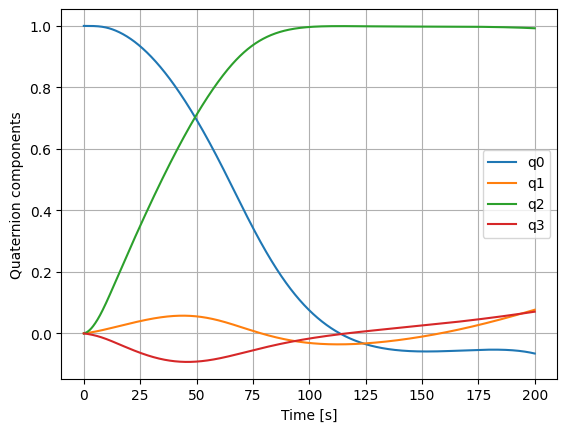

C:\Users\franklin\AppData\Local\Temp\ipykernel_17292\3270284574.py:221: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point_error[0,i] = math.acos(BR[2,2])


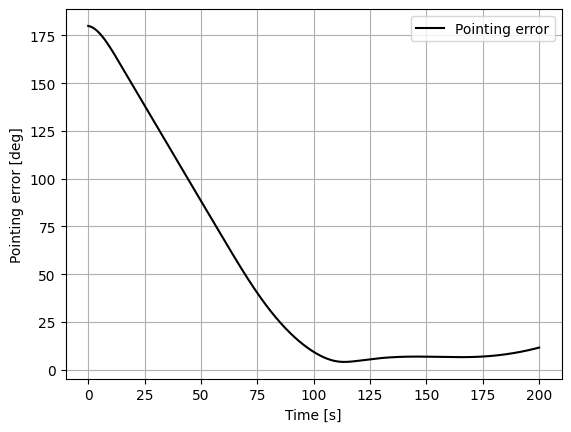

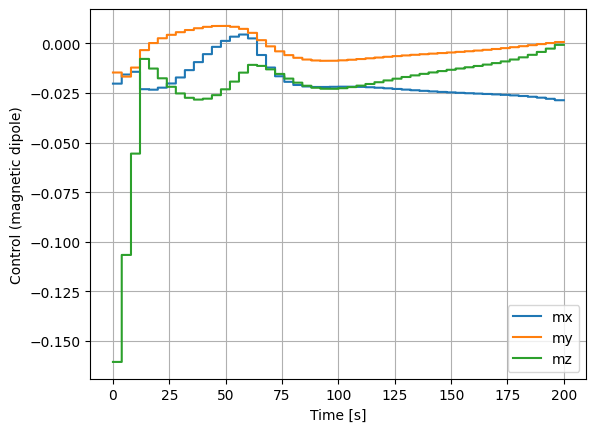

In [458]:
import numpy as np
import matplotlib.pyplot as plt

def u_interpol_zoh(t, u_value, dt_control):
    """
    Zero-order hold interpolation
    u_value: shape (3, T_control)
    dt_control: paso de discretización del control
    """

    T_control = u_value.shape[1]

    index = int(np.floor(t / dt_control))

    if index >= T_control:
        index = T_control - 1

    return u_value[:, index]

def u_interpol_linear(t, u_value, dt_control):
    """
    Linear interpolation of control input

    Parameters
    ----------
    t : float
        Current simulation time
    u_value : ndarray shape (3, T_control)
        Discrete control samples
    dt_control : float
        Control sampling time

    Returns
    -------
    u_interp : ndarray shape (3,)
        Interpolated control vector at time t
    """

    T_control = u_value.shape[1]

    # Índice inferior
    index = int(np.floor(t / dt_control))

    # Si estamos fuera del rango → mantener último valor
    if index >= T_control - 1:
        return u_value[:, -1]

    # Tiempo local dentro del intervalo
    t0 = index * dt_control
    alpha = (t - t0) / dt_control  # 0 ≤ alpha < 1

    # Interpolación lineal
    u0 = u_value[:, index]
    u1 = u_value[:, index + 1]

    return (1 - alpha) * u0 + alpha * u1

def quat_to_dcm(q):
    q0, q1, q2, q3 = q
    return np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2*(q1*q2 + q0*q3), 2*(-q0*q2 + q1*q3)],
        [2*(q1*q2 - q0*q3), q0**2 - q1**2 + q2**2 - q3**2, 2*(q0*q1 + q2*q3)],
        [2*(q0*q2 + q1*q3), 2*(-q0*q1 + q2*q3), q0**2 - q1**2 - q2**2 + q3**2]
    ])

def dcm_ZXZ(Omega, inc, theta):
    cO = np.cos(Omega)
    sO = np.sin(Omega)
    ci = np.cos(inc)
    si = np.sin(inc)
    ct = np.cos(theta)
    st = np.sin(theta)

    Rz1 = np.array([[cO, -sO, 0],
                    [sO,  cO, 0],
                    [0,   0,  1]])

    Rx  = np.array([[1, 0, 0],
                    [0, ci, -si],
                    [0, si,  ci]])

    Rz2 = np.array([[ct, -st, 0],
                    [st,  ct, 0],
                    [0,   0,  1]])

    return (Rz1 @ Rx @ Rz2).T


# =============================
# Dinámica
# =============================

def dynamics(t, x, u, params):

    q = x[0:4]
    w = x[4:7]
    m = u

    I = params["I"]
    I_inv = params["I_inv"]
    n = params["n"]
    Omega = params["Omega"]
    inc = params["inc"]
    B0 = params["B0"]

    O_B = np.array([
        -2*np.sin(inc)*np.cos(n*t),
        -np.sin(inc)*np.sin(n*t),
         np.cos(inc)
    ]) * B0

    BN = quat_to_dcm(q)
    ON = dcm_ZXZ(Omega, inc, n*t)
    BO = BN @ ON.T

    torque = np.cross(m, BO @ O_B)

    w_dot = I_inv @ (-np.cross(w, I @ w) + torque)

    q0, q1, q2, q3 = q
    wx, wy, wz = w

    q_dot = 0.5 * np.array([
        -wx*q1 - wy*q2 - wz*q3,
         wx*q0 + wz*q2 - wy*q3,
         wy*q0 - wz*q1 + wx*q3,
         wz*q0 + wy*q1 - wx*q2
    ])

    return np.concatenate((q_dot, w_dot))


# =============================
# RK4
# =============================

def rk4_step(f, t, x, u, dt, params):

    k1 = f(t, x, u, params)
    k2 = f(t + dt/2, x + dt/2 * k1, u, params)
    k3 = f(t + dt/2, x + dt/2 * k2, u, params)
    k4 = f(t + dt, x + dt * k3, u, params)

    x_next = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # Normalizar cuaternión
    x_next[0:4] /= np.linalg.norm(x_next[0:4])

    return x_next


# =============================
# Simulación
# =============================

inertia_error = 0.00000 
I = np.array([[J1_double, inertia_error, inertia_error],
              [inertia_error, J2_double + inertia_error, inertia_error],
              [inertia_error, inertia_error, J3_double]])

params = {
    "I": I,
    "I_inv": np.linalg.inv(I),
    "n": n_cubesat_double,
    "Omega": Omega_double,
    "inc": inc_double,
    "B0": B0_double
}

x = np.array([start_quat[0,0], start_quat[1,0], start_quat[2,0], start_quat[3,0], start_w_xyz[0,0], start_w_xyz[1,0], start_w_xyz[2,0]])

dt_state = 0.1 # step RK4 (closed loop)
dt_control = tau_double  # COGU control each tau_double [s]
N = int(tf/dt_state)+1

q_history = np.zeros((N, 4))
t_history = np.zeros(N)
u_history = np.zeros((N, 3))
t=0

for i in range(N):
    q_history[i] = x[0:4]
    t_history[i] = t

    u_current = u_interpol_zoh(t, u_value, dt_control)
    #u_current = u_interpol_linear(t, u_value, dt_control)
    
    u_history[i] = u_current   # <-- guardar control

    x = rk4_step(dynamics, t, x, u_current, dt_state, params)
    t += dt_state


# =============================
# Plot quaternion
# =============================

plt.figure(1)
plt.plot(t_history, q_history[:, 0])
plt.plot(t_history, q_history[:, 1])
plt.plot(t_history, q_history[:, 2])
plt.plot(t_history, q_history[:, 3])
plt.xlabel("Time [s]")
plt.ylabel("Quaternion components")
plt.legend(["q0", "q1", "q2", "q3"])
plt.grid(True)
plt.show()


# --- Pointing error ---
plt.figure(2)

rot_RN = R.from_quat(end_quat.T)
RN = rot_RN.as_matrix()
point_error = np.zeros((1,N))

for i in range(N):
    rot_BN = R.from_quat(q_history[i, :])
    BN = rot_BN.as_matrix()
    BR = BN@RN.T
    point_error[0,i] = math.acos(BR[2,2])

plt.plot(t_history, point_error[0,:]*180/np.pi, 'k', label='Pointing error')
plt.grid(); plt.legend(); plt.xlabel('Time [s]');plt.ylabel('Pointing error [deg]')

plt.figure()
plt.step(t_history, u_history[:, 0])
plt.step(t_history, u_history[:, 1])
plt.step(t_history, u_history[:, 2])
plt.xlabel("Time [s]")
plt.ylabel("Control (magnetic dipole)")
plt.legend(["mx", "my", "mz"])
plt.grid(True)
plt.show()